# Modular COPD Modeling Pipeline
This notebook is a refactored version of the full pipeline. Each step is wrapped in modular functions, cleaned of redundancy

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, QuantileRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from linearmodels.panel import PanelOLS

In [4]:
# Read Data

path='./Data/merged_burden_risk.csv'

df = pd.read_csv(path)

In [5]:
#rename columns for ease 

df = df.dropna(subset=['dalys_(disability-adjusted_life_years)'])
df.rename(columns={'Chronic_Respiratory(RSD)': 'RSD'}, inplace=True)
df.rename(columns={'dalys_(disability-adjusted_life_years)': 'DALYs'}, inplace=True)
df = df.sort_values(by=['country', 'year'])

In [6]:
#filling in missing data for HAQ_Index and RSD using Linear Interpolation and Regression Imputation

# Step 1: Linear interpolation (within each country)
for col in ['HAQ_Index', 'RSD']:
    df[col] = df.groupby('country')[col].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

# Step 2: Fill remaining HAQ using regression on year
if df['HAQ_Index'].isna().sum() > 0:
    known = df[df['HAQ_Index'].notna()]
    unknown = df[df['HAQ_Index'].isna()]
    model = LinearRegression().fit(known[['year']], known['HAQ_Index'])
    df.loc[unknown.index, 'HAQ_Index'] = model.predict(unknown[['year']])

# Step 3: Fill remaining RSD (if any) using regression
if df['RSD'].isna().sum() > 0:
    known_rsd = df[df['RSD'].notna()]
    unknown_rsd = df[df['RSD'].isna()]
    model_rsd = LinearRegression().fit(known_rsd[['year']], known_rsd['RSD'])
    df.loc[unknown_rsd.index, 'RSD'] = model_rsd.predict(unknown_rsd[['year']])

### Feature Transformations

In [7]:
#Log Transformations: Normalize skewed variables
df['log_gdp_per_capita'] = np.log(df['GDP PER CAPITA (USD)'] + 1)
df['log_population_density'] = np.log(df['Population Density'] + 1)
df['log_total_co2'] = np.log(df['Total CO2 Emission excluding LUCF (Mt)'] + 1)


#Per Capita Pollution Measures: Scale pollution to population for fair comparisons
df['co2_per_capita'] = df['Total CO2 Emission excluding LUCF (Mt)'] / df['Population']
df['no2_per_capita'] = df['Nitrogen oxide'] / df['Population']
df['black_carbon_per_capita'] = df['Black Carbon'] / df['Population']

#Pollution burden adjusted for healthcare quality
df['pollution_x_low_haq'] = df['co2_per_capita'] * (1 - df['HAQ_Index'] / 100)

df['year_index'] = df['year'] - df['year'].min() #Time Index: Relative year index

df['lagged_dalys'] = df.groupby('country')['DALYs'].shift(1) #Lagged DALYs: Previous year's burden for temporal modeling

df.head()


,country,Sub-Region,year,Population,GDP PER CAPITA (USD),Area (Km2),Population Density,Total CO2 Emission excluding LUCF (Mt),Nitrogen oxide,Sulphur dioxide,...,smoking_YLL,log_gdp_per_capita,log_population_density,log_total_co2,co2_per_capita,no2_per_capita,black_carbon_per_capita,pollution_x_low_haq,year_index,lagged_dalys
0,algeria,Northern Africa,2000,30774621,1780.38,2381741,12.921061,80.05,259742.44,99556.484,...,19088,7.485144,2.633403,4.395066,0.000003,0.008440,0.001715,0.000001,0,NaN
1,algeria,Northern Africa,2001,31200985,1754.58,2381741,13.100075,78.65,259294.86,91087.230,...,19447,7.470555,2.646180,4.377642,0.000003,0.008310,0.001509,0.000001,1,76462.0
2,algeria,Northern Africa,2002,31624696,1794.81,2381741,13.277974,82.40,293826.30,118613.930,...,20062,7.493211,2.658718,4.423648,0.000003,0.009291,0.001538,0.000001,2,78867.0
3,algeria,Northern Africa,2003,32055883,2117.05,2381741,13.459013,88.19,289759.84,108086.620,...,20779,7.658251,2.671318,4.490769,0.000003,0.009039,0.001531,0.000001,3,82146.0
4,algeria,Northern Africa,2004,32510186,2624.80,2381741,13.649757,89.49,315098.84,121832.650,...,21397,7.873141,2.684424,4.505239,0.000003,0.009692,0.001523,0.000001,4,85619.0


### Advanced Feature Engineering

In [8]:
#Rolling Averages: Capture long-term exposure effects
df['pm25_3yr_avg'] = df.groupby('country')['pm25_DALY'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['dalys_3yr_avg'] = df.groupby('country')['DALYs'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

#Temporal Change: Year-over-year change in pollution
df['delta_pm25'] = df.groupby('country')['pm25_DALY'].diff()
df['delta_black_carbon'] = df.groupby('country')['Black Carbon'].diff()

#Interaction Terms: Capture compound effects between variables
df['gdp_x_haq'] = df['GDP PER CAPITA (USD)'] * df['HAQ_Index']
df['smoking_x_pm25'] = df['smoking_DALY'] * df['pm25_DALY']
df['haq_x_dalys_lag'] = df['HAQ_Index'] * df.groupby('country')['DALYs'].shift(1)

#Vulnerability Index: Composite of low GDP, high population density, and low HAQ
df['norm_gdp'] = df.groupby('year')['GDP PER CAPITA (USD)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_density'] = df.groupby('year')['Population Density'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_haq'] = df.groupby('year')['HAQ_Index'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['vulnerability_index'] = (1 - df['norm_gdp']) + df['norm_density'] + (1 - df['norm_haq'])


# Preview key new features
df[['log_gdp_per_capita', 'co2_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
    'delta_pm25', 'gdp_x_haq', 'vulnerability_index']].head()

,log_gdp_per_capita,co2_per_capita,pollution_x_low_haq,pm25_3yr_avg,delta_pm25,gdp_x_haq,vulnerability_index
0,7.485144,0.000003,0.000001,18436.000000,NaN,90087.2280,1.043238
1,7.470555,0.000003,0.000001,18696.500000,521.0,90431.0532,1.035506
2,7.493211,0.000003,0.000001,18994.000000,632.0,94191.6288,1.033777
3,7.658251,0.000003,0.000001,19588.666667,631.0,113092.8110,0.989745
4,7.873141,0.000003,0.000001,20190.666667,543.0,142684.1280,0.967272


In [9]:
all_features = [
    'log_gdp_per_capita', 'log_population_density', 'log_total_co2',
    'co2_per_capita', 'pollution_x_low_haq', 'year_index', 'lagged_dalys',
    'pm25_3yr_avg', 'delta_pm25', 'gdp_x_haq', 'smoking_x_pm25',
    'haq_x_dalys_lag', 'vulnerability_index'
]

structural_features = [f for f in all_features if f not in ['lagged_dalys', 'haq_x_dalys_lag']]

In [10]:
def prepare_feature_set(df, feature_list):
    df_model = df.dropna(subset=feature_list + ['DALYs']).copy()
    X = df_model[feature_list]
    y = df_model['DALYs']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42), feature_list

In [11]:
def get_models():
    return {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Quantile Regression (median)': QuantileRegressor(quantile=0.5, alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    }

In [12]:
def evaluate_multiple_models(models, X_train, X_test, y_train, y_test):
    results = []
    predictions = {}
    mean_dalys = y_test.mean()

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        predictions[name] = preds
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        results.append({
            'Model': name,
            'R²': round(r2, 4),
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'RMSE as % of Mean DALYs': f"{(rmse / mean_dalys):.2%}"
        })

    return pd.DataFrame(results).sort_values(by='R²', ascending=False).reset_index(drop=True), predictions

In [13]:
# Prepare data for modelling
(df_temp_split, temp_features) = prepare_feature_set(df, all_features)
(X_temp_train, X_temp_test, y_temp_train, y_temp_test) = df_temp_split

(df_struct_split, struct_features) = prepare_feature_set(df, structural_features)
(X_struct_train, X_struct_test, y_struct_train, y_struct_test) = df_struct_split

# Train all models and evaluate
models = get_models()

results_temp, preds_temp_dict = evaluate_multiple_models(models, X_temp_train, X_temp_test, y_temp_train, y_temp_test)
results_temp["Feature Set"] = "Temporal"

results_struct, preds_struct_dict = evaluate_multiple_models(models, X_struct_train, X_struct_test, y_struct_train, y_struct_test)
results_struct["Feature Set"] = "Structural"



In [14]:
# Results for models according to feature sets
temporal_df = pd.concat([
    results_temp,
], ignore_index=True)

display(temporal_df.sort_values(by='RMSE as % of Mean DALYs', ascending=True).reset_index(drop=True))


structural_df = pd.concat([
    results_struct,
], ignore_index=True)

structural_df["RMSE as % of Mean DALYs"] = structural_df["RMSE as % of Mean DALYs"].str.rstrip('%').astype(float)
display(structural_df.sort_values(by='RMSE as % of Mean DALYs', ascending=True).reset_index(drop=True))

,Model,R²,MAE,RMSE,RMSE as % of Mean DALYs,Feature Set
0,Lasso Regression,0.9997,767.89,1386.94,2.21%,Temporal
1,Linear Regression,0.9997,768.34,1387.52,2.22%,Temporal
2,Quantile Regression (median),0.9997,723.92,1390.53,2.22%,Temporal
3,Ridge Regression,0.9997,833.61,1502.97,2.40%,Temporal
4,XGBoost,0.9993,920.21,2183.67,3.49%,Temporal
5,Random Forest,0.9989,879.76,2790.72,4.46%,Temporal


,Model,R²,MAE,RMSE,RMSE as % of Mean DALYs,Feature Set
0,Random Forest,0.9965,2560.39,4987.64,7.96,Structural
1,XGBoost,0.9943,2835.91,6312.42,10.08,Structural
2,Ridge Regression,0.8401,23773.56,33518.71,53.52,Structural
3,Linear Regression,0.8396,23753.54,33567.70,53.60,Structural
4,Lasso Regression,0.8396,23753.58,33567.68,53.60,Structural
5,Quantile Regression (median),0.5972,28935.18,53197.45,84.94,Structural


In [16]:
# Combine the results for comparison
comparison_df = pd.concat([
    results_temp,
    results_struct,
], ignore_index=True)

# Convert RMSE % string to numeric float column
comparison_df["RMSE_pct"] = comparison_df["RMSE as % of Mean DALYs"].str.rstrip('%').astype(float)

# Sort by numeric RMSE percentage
comparison_df_sorted = comparison_df.sort_values(by='RMSE_pct', ascending=True).reset_index(drop=True)

# Display
display(comparison_df_sorted)

,Model,R²,MAE,RMSE,RMSE as % of Mean DALYs,Feature Set,RMSE_pct
0,Lasso Regression,0.9997,767.89,1386.94,2.21%,Temporal,2.21
1,Linear Regression,0.9997,768.34,1387.52,2.22%,Temporal,2.22
2,Quantile Regression (median),0.9997,723.92,1390.53,2.22%,Temporal,2.22
3,Ridge Regression,0.9997,833.61,1502.97,2.40%,Temporal,2.40
4,XGBoost,0.9993,920.21,2183.67,3.49%,Temporal,3.49
5,Random Forest,0.9989,879.76,2790.72,4.46%,Temporal,4.46
6,Random Forest,0.9965,2560.39,4987.64,7.96%,Structural,7.96
7,XGBoost,0.9943,2835.91,6312.42,10.08%,Structural,10.08
8,Ridge Regression,0.8401,23773.56,33518.71,53.52%,Structural,53.52
9,Linear Regression,0.8396,23753.54,33567.70,53.60%,Structural,53.60


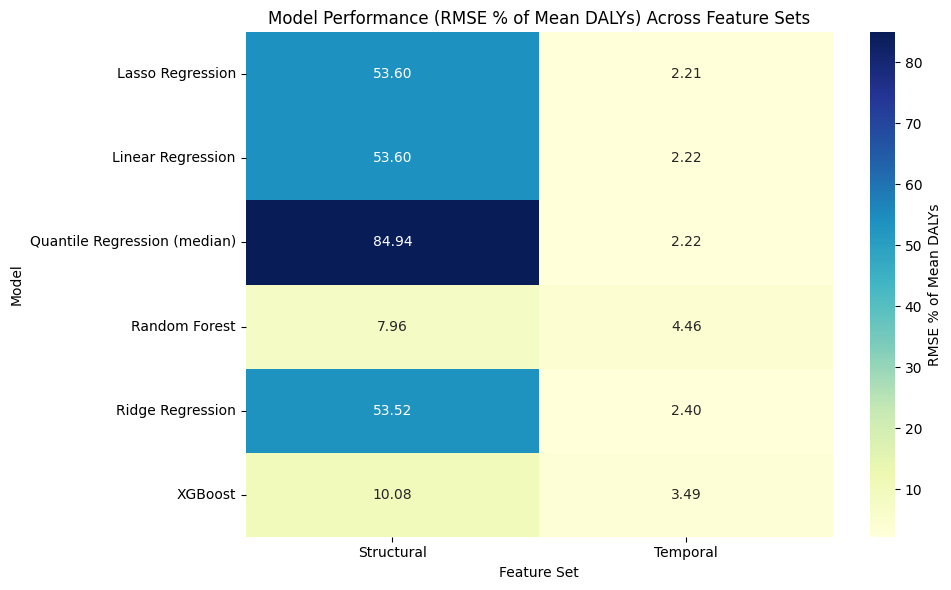

In [17]:

# Step 2: Pivot the DataFrame to prepare for heatmap
heatmap_matrix = comparison_df.pivot_table(
    index="Model",
    columns="Feature Set",
    values="RMSE_pct"
)

# Step 3: Plot heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'RMSE % of Mean DALYs'}
)
plt.title("Model Performance (RMSE % of Mean DALYs) Across Feature Sets")
plt.ylabel("Model")
plt.xlabel("Feature Set")
plt.tight_layout()
plt.show()

In [18]:
df

,country,Sub-Region,year,Population,GDP PER CAPITA (USD),Area (Km2),Population Density,Total CO2 Emission excluding LUCF (Mt),Nitrogen oxide,Sulphur dioxide,...,dalys_3yr_avg,delta_pm25,delta_black_carbon,gdp_x_haq,smoking_x_pm25,haq_x_dalys_lag,norm_gdp,norm_density,norm_haq,vulnerability_index
0,algeria,Northern Africa,2000,30774621,1780.38,2381741,12.921061,80.05,259742.440,99556.484,...,76462.000000,NaN,NaN,90087.228000,481345524,NaN,0.208725,0.018492,0.766529,1.043238
1,algeria,Northern Africa,2001,31200985,1754.58,2381741,13.100075,78.65,259294.860,91087.230,...,77664.500000,521.0,-5673.450,90431.053200,507478890,3.940851e+06,0.203549,0.018576,0.779521,1.035506
2,algeria,Northern Africa,2002,31624696,1794.81,2381741,13.277974,82.40,293826.300,118613.930,...,79158.333333,632.0,1537.963,94191.628800,543281326,4.138940e+06,0.192416,0.018685,0.792492,1.033777
3,algeria,Northern Africa,2003,32055883,2117.05,2381741,13.459013,88.19,289759.840,108086.620,...,82210.666667,631.0,447.641,113092.811000,583043700,4.388239e+06,0.223615,0.018801,0.805441,0.989745
4,algeria,Northern Africa,2004,32510186,2624.80,2381741,13.649757,89.49,315098.840,121832.650,...,85594.666667,543.0,422.000,142684.128000,619214949,4.654249e+06,0.233314,0.018955,0.818369,0.967272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,zimbabwe,Eastern Africa,2016,14452704,1421.79,390757,36.986424,10.45,75121.300,60993.727,...,41666.333333,31.0,245.217,44359.848000,43147126,1.297608e+06,0.077750,0.055414,0.240000,1.737665
1088,zimbabwe,Eastern Africa,2017,14751101,1192.11,390757,37.750062,9.78,75438.190,53499.797,...,42740.333333,-60.0,822.894,36151.568494,43284206,1.297485e+06,0.060314,0.056525,0.256913,1.739298
1089,zimbabwe,Eastern Africa,2018,15052184,2269.18,390757,38.520574,11.07,83017.195,56813.844,...,43881.666667,-59.0,1067.071,66830.521256,43504128,1.291326e+06,0.125924,0.057666,0.266045,1.665697
1090,zimbabwe,Eastern Africa,2019,15354608,1421.87,390757,39.294518,10.19,80245.730,53119.727,...,44973.666667,6.0,501.578,40632.914978,44498289,1.286369e+06,0.072435,0.058825,0.275439,1.710951


In [43]:
#Panel Modeling — Random Effects Approximation (OLS + Clustered SE)
# STEP 6A: Random Effects-style Panel Regression (with Clustered SEs)

# Feature list
candidate_features = [
    'log_gdp_per_capita',
    'pollution_x_low_haq',
    'pm25_3yr_avg',
    'smoking_x_pm25',
    'vulnerability_index'
]

# Prepare panel structure
df = df.set_index(['country', 'year'])
panel_df = df[candidate_features + ['DALYs']].dropna().copy()
panel_df['const'] = 1

# Remove collinear feature
final_features = candidate_features.copy()
for feature in candidate_features:
    test_features = [f for f in final_features if f != feature]
    X = panel_df[test_features + ['const']]
    if matrix_rank(X.values) == len(test_features) + 1:
        final_features = test_features
        break

# Final regression design
X_final = panel_df[final_features + ['const']]

# VIF check
vif_data = pd.DataFrame()
vif_data["feature"] = final_features
vif_data["VIF"] = [variance_inflation_factor(X_final[final_features].values, i) for i in range(len(final_features))]

# Run PanelOLS
model = PanelOLS(panel_df['DALYs'], X_final, entity_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Output
print(results.summary)
print(vif_data)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  DALYs   R-squared:                        0.6994
Estimator:                   PanelOLS   R-squared (Between):              0.4879
No. Observations:                 289   R-squared (Within):               0.6994
Date:                Tue, Apr 08 2025   R-squared (Overall):              0.5727
Time:                        18:50:11   Log-likelihood                   -2960.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      135.53
Entities:                          52   P-value                           0.0000
Avg Obs:                       5.5577   Distribution:                   F(4,233)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             28.149
                            

In [ ]:
#Panel Modeling — Random Effects Approximation (OLS + Clustered SE)
# STEP 6A: Random Effects-style Panel Regression (with Clustered SEs)

# === 3. Select features for modeling ===
# Step 1: Set up your panel features
panel_features = [
    'log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
    'gdp_x_haq', 'smoking_x_pm25', 'haq_x_dalys_lag', 'vulnerability_index'
]

# Step 2: Set index but DON'T reference 'country', 'year' as columns
#df = df.set_index(['country', 'year'])

# Step 3: Extract panel data, then bring 'country' back from index for clustering
panel_df = df[panel_features + ['DALYs']].dropna().copy()
panel_df['cluster_group'] = panel_df.index.get_level_values('country')  # <--- this is key!

# Step 4: Define model inputs
X = sm.add_constant(panel_df[panel_features])
y = panel_df['DALYs']

# Step 5: Fit model with cluster-robust SEs
model = sm.OLS(y, X)
re_results = model.fit(cov_type='cluster', cov_kwds={'groups': panel_df['cluster_group']})


# === 6. Print results summary ===
print(re_results.summary())
# 📘 Notes:

# This approximates Random Effects by clustering standard errors by country
# It controls for within-country correlation while pooling across countries
# For true RE, you can use linearmodels.RandomEffects() if you're set up for that

In [ ]:
# STEP 6A-2: First-Difference Panel Regression


# Define the columns
features = [
    'DALYs', 'log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
    'gdp_x_haq', 'smoking_x_pm25', 'haq_x_dalys_lag', 'vulnerability_index'
]

# Step 1: Clean sub-dataframe

df_sub = df.reset_index()[['country', 'year'] + features].dropna()

# Step 2: First differences per country
diff_rows = []
group_labels = []

for country, group in df_sub.groupby('country'):
    group_sorted = group.sort_values('year')
    diffs = group_sorted[features].diff().dropna()
    diffs['country'] = country
    diff_rows.append(diffs)
    group_labels.extend([country] * len(diffs))

df_diff = pd.concat(diff_rows).reset_index(drop=True)

# Step 3: Set up X and y
X_diff = sm.add_constant(df_diff.drop(columns=['DALYs', 'country']))
y_diff = df_diff['DALYs']
group_var = df_diff['country']

# Step 4: Fit model with clustered standard errors
model = sm.OLS(y_diff, X_diff)
fd_results = model.fit(cov_type='cluster', cov_kwds={'groups': group_var})

# Step 5: Print the summary
print(fd_results.summary())


In [ ]:
# ✅ Panel Models for deaths

# STEP 6A EXTENSION: Panel Regression on COPD Deaths

import pandas as pd
import numpy as np
import statsmodels.api as sm

# === 1. Load and Prepare Dataset ===
df = pd.read_csv("merged_burden_risk.csv")
df = df.dropna(subset=['deaths'])  # use exact column name
df.rename(columns={'deaths': 'TARGET'}, inplace=True)
df = df.sort_values(by=['country', 'year'])

# === 2. Feature Engineering (Static) ===
df['log_gdp_per_capita'] = np.log(df['GDP PER CAPITA (USD)'] + 1)
df['log_population_density'] = np.log(df['Population Density'] + 1)
df['log_total_co2'] = np.log(df['Total CO2 Emission excluding LUCF (Mt)'] + 1)
df['co2_per_capita'] = df['Total CO2 Emission excluding LUCF (Mt)'] / df['Population']
df['pollution_x_low_haq'] = df['co2_per_capita'] * (1 - df['HAQ_Index'].fillna(0) / 100)
df['pm25_3yr_avg'] = df.groupby('country')['pm25_DALY'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['gdp_x_haq'] = df['GDP PER CAPITA (USD)'] * df['HAQ_Index'].fillna(0)
df['smoking_x_pm25'] = df['smoking_DALY'] * df['pm25_DALY']
df['haq_x_target_lag'] = df['HAQ_Index'].fillna(0) * df.groupby('country')['TARGET'].shift(1)
df['norm_gdp'] = df.groupby('year')['GDP PER CAPITA (USD)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_density'] = df.groupby('year')['Population Density'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_haq'] = df.groupby('year')['HAQ_Index'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['vulnerability_index'] = (1 - df['norm_gdp']) + df['norm_density'] + (1 - df['norm_haq'])

# === 3. Select Features and Drop Missing ===
features = [
    'TARGET', 'log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
    'gdp_x_haq', 'smoking_x_pm25', 'haq_x_target_lag', 'vulnerability_index'
]
df_sub = df[['country', 'year'] + features].dropna()

# === 4. RANDOM EFFECTS-STYLE MODEL (Clustered OLS) ===
X = sm.add_constant(df_sub[['log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
                            'gdp_x_haq', 'smoking_x_pm25', 'haq_x_target_lag', 'vulnerability_index']])
y = df_sub['TARGET']
re_model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': df_sub['country']})
print("🔹 RANDOM EFFECTS MODEL RESULTS FOR DEATHS")
print(re_model.summary())

# === 5. FIRST-DIFFERENCE MODEL ===
diff_rows = []
for country, group in df_sub.groupby('country'):
    group = group.sort_values('year')
    diffs = group[features].diff().dropna()
    diffs['country'] = country
    diff_rows.append(diffs)

df_diff = pd.concat(diff_rows).reset_index(drop=True)
X_diff = sm.add_constant(df_diff[['log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
                                  'gdp_x_haq', 'smoking_x_pm25', 'haq_x_target_lag', 'vulnerability_index']])
y_diff = df_diff['TARGET']
fd_model = sm.OLS(y_diff, X_diff).fit(cov_type='cluster', cov_kwds={'groups': df_diff['country']})
print("\n🔹 FIRST-DIFFERENCE MODEL RESULTS FOR DEATHS")
print(fd_model.summary())


In [ ]:
#### Interpretation Guidance

 # After running:

 # Focus on sign and magnitude of:
# pollution_x_low_haq
# pm25_3yr_avg
# smoking_x_pm25
# These represent how structural pollution exposure and health system quality affect mortality 

In [ ]:
# Final robust, dynamic SARIMAX forecasting module with enhancements included step 6b

def forecast_copd_country_robust(
    df,
    country: str,
    target_column: str,
    exog_columns: list,
    forecast_years: int = 9,
    arima_order=(1, 1, 1),
    simulate_growth: dict = None,
    display_plot: bool = True
):
    """
    SARIMAX forecast for a country's COPD burden (deaths, DALYs, etc.) with optional scenario simulation.

    Args:
        df (pd.DataFrame): Full dataset with 'country' and 'year'.
        country (str): Name of the country to forecast.
        target_column (str): Column to forecast (e.g., 'deaths').
        exog_columns (list): List of exogenous variable names.
        forecast_years (int): How many years to forecast ahead.
        arima_order (tuple): SARIMAX (p,d,q) configuration.
        simulate_growth (dict): Optional % growth/decline for exog features.
        display_plot (bool): Whether to plot the results.

    Returns:
        dict: Forecast, confidence intervals, RMSE, MAE, and fitted values.
    """

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # Step 1: Filter country and set datetime index
    df = df.copy()
    df['country'] = df['country'].str.lower()
    country = country.lower()
    country_df = df[df['country'] == country].sort_values('year')

    if 'year' not in country_df.columns:
        raise ValueError("Column 'year' must be present in your dataset.")

    country_df['year'] = pd.to_datetime(country_df['year'], format='%Y')
    country_df = country_df.set_index('year')

    # Step 2: Create any engineered variables
    if 'black_carbon_per_capita' in exog_columns and 'black_carbon_per_capita' not in country_df.columns:
        if 'Black Carbon' in country_df.columns and 'Population' in country_df.columns:
            country_df['black_carbon_per_capita'] = country_df['Black Carbon'] / country_df['Population']
        else:
            raise ValueError("'Black Carbon' or 'Population' missing for computing 'black_carbon_per_capita'")

    # Step 3: Ensure all required columns are present
    required_cols = [target_column] + exog_columns
    for col in required_cols:
        if col not in country_df.columns:
            raise ValueError(f"Column '{col}' is missing in the dataset.")

    # Step 4: Drop NA and confirm enough data
    country_df = country_df.dropna(subset=required_cols)

    if country_df.empty or country_df.shape[0] < 5:
        raise ValueError(f"Insufficient data for {country.title()} to model '{target_column}'")

    # Step 5: Prepare model inputs
    y = country_df[target_column]
    X = country_df[exog_columns]

    # Step 6: Fit SARIMAX model
    model = SARIMAX(endog=y, exog=X, order=arima_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)

    # Step 7: Simulate future exogenous variables
    last_known = X.iloc[-1]
    future_index = pd.date_range(start=y.index[-1] + pd.DateOffset(years=1), periods=forecast_years, freq='Y')
    future_exog = pd.DataFrame(index=future_index)

    for var in exog_columns:
        growth = simulate_growth.get(var, 0.0) if simulate_growth else 0.0
        future_exog[var] = [last_known[var] * ((1 + growth) ** i) for i in range(1, forecast_years + 1)]

    # Step 8: Forecast
    forecast_result = fit.get_forecast(steps=forecast_years, exog=future_exog)
    forecast_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()

    # Step 9: Evaluate training error
    y_pred_train = fit.fittedvalues
    rmse = mean_squared_error(y, y_pred_train, squared=False)
    mae = mean_absolute_error(y, y_pred_train)

    # Step 10: Plot
    if display_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(y.index.year, y, label="Observed")
        plt.plot(y_pred_train.index.year, y_pred_train, linestyle='--', color='gray', alpha=0.6, label="Fitted")
        plt.plot(forecast_mean.index.year, forecast_mean, color='orange', linestyle='--', label="Forecast")
        plt.fill_between(forecast_mean.index.year, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                         color='orange', alpha=0.2, label="95% CI")
        plt.title(f"{target_column.title()} Forecast for {country.title()}")
        plt.xlabel("Year")
        plt.ylabel(target_column)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "forecast": forecast_mean,
        "confidence_interval": conf_int,
        "rmse": rmse,
        "mae": mae,
        "train_fitted": y_pred_train
    }


In [ ]:
results = forecast_copd_country_robust(
    df=pd.read_csv("merged_burden_risk.csv"),
    country="Nigeria",
    target_column="deaths",
    exog_columns=["GDP PER CAPITA (USD)", "pm25_DALY", "smoking_DALY", "black_carbon_per_capita"],
    simulate_growth={
        "GDP PER CAPITA (USD)": 0.03,
        "pm25_DALY": -0.01,
        "black_carbon_per_capita": -0.02
    },
    forecast_years=10
)

print("RMSE:", results['rmse'])
print("MAE:", results['mae'])

In [ ]:
# Re-run the SARIMA baseline forecast for Nigeria (robust version accounting for lowercase names)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load dataset
df = pd.read_csv("/mnt/data/merged_burden_risk.csv")

# Normalize country names to lowercase for consistency
df['country'] = df['country'].str.lower()

# Use 'nigeria' in lowercase
country_name = 'nigeria'
target_column = 'dalys_(disability-adjusted_life_years)'

# Filter and clean
df_country = df[df['country'] == country_name].copy()
df_country = df_country[['year', target_column]].dropna()

# Validate data sufficiency
if df_country.empty or len(df_country) < 5:
    raise ValueError(f"❌ Insufficient '{target_column}' data for {country_name.title()}")

# Prepare time index
df_country['year'] = pd.to_datetime(df_country['year'], format='%Y')
df_country.set_index('year', inplace=True)
target = df_country[target_column]

# Fit SARIMA model (baseline, no exog)
model = SARIMAX(target, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecast 9 future years
future_years = 9
forecast = model_fit.get_forecast(steps=future_years)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate historical fit
fitted_vals = model_fit.fittedvalues
rmse = mean_squared_error(target, fitted_vals, squared=False)
mae = mean_absolute_error(target, fitted_vals)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(target.index.year, target, label="Historical DALYs")
plt.plot(fitted_vals.index.year, fitted_vals, linestyle='--', alpha=0.5, label="Fitted (Train)")
plt.plot(forecast_mean.index.year, forecast_mean, linestyle="--", color="darkred", label="Forecast (2022–2030)")
plt.fill_between(forecast_mean.index.year, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.2, color="salmon", label="95% CI")
plt.title(f"Baseline SARIMA Forecast of DALYs in {country_name.title()} (No Exog)")
plt.xlabel("Year")
plt.ylabel("DALYs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output accuracy
{
    "RMSE": rmse,
    "MAE": mae,
    "Forecast (2022–2030)": forecast_mean
}


In [ ]:
# # Fixing the plotting error with safe .year extraction and NumPy conversion
# plt.figure(figsize=(12, 6))

# # Extract years safely as integer array
# forecast_years = forecast_mean.index.year.values
# actual_years = target.index.year.values
# fitted_years = fitted_vals.index.year.values

# # Plot historical and fitted
# plt.plot(actual_years, target.values, label="Historical DALYs")
# plt.plot(fitted_years, fitted_vals.values, linestyle='--', alpha=0.5, label="Fitted (Train)")

# # Plot forecast
# plt.plot(forecast_years, forecast_mean.values, linestyle="--", color="darkred", label="Forecast (2022–2030)")
# plt.fill_between(
#     forecast_years,
#     conf_int.iloc[:, 0].values,
#     conf_int.iloc[:, 1].values,
#     alpha=0.2,
#     color="salmon",
#     label="95% CI"
# )

# plt.title("Baseline SARIMA Forecast of DALYs in Nigeria (No Exogenous Variables)")
# plt.xlabel("Year")
# plt.ylabel("DALYs")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
# Load and rank countries by latest DALYs to determine top-5
df = pd.read_csv("/mnt/data/merged_burden_risk.csv")
df['country'] = df['country'].str.lower()

# Get most recent year of DALYs per country
latest_years = df.groupby('country')['year'].max().reset_index()
latest_dalys = df.merge(latest_years, on=['country', 'year'], how='inner')
top5 = (
    latest_dalys[['country', 'dalys_(disability-adjusted_life_years)']]
    .dropna()
    .sort_values(by='dalys_(disability-adjusted_life_years)', ascending=False)
    .head(5)['country']
    .tolist()
)

top5


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === 1. Load and prepare data ===
df = pd.read_csv("merged_burden_risk.csv")
df['country'] = df['country'].str.lower()

# === 2. Forecast targets and container ===
forecast_targets = ['dalys_(disability-adjusted_life_years)', 'deaths']
forecast_results = {}

# === 3. Loop through countries and forecast ===
for country in ['nigeria', 'south africa', 'democratic republic of congo', 'egypt', 'ethiopia']:
    forecast_results[country] = {}
    for target_column in forecast_targets:
        df_cty = df[df['country'] == country].copy()
        df_cty = df_cty[['year', target_column]].dropna()

        if len(df_cty) < 5:
            print(f"⏩ Skipping {country} - {target_column}: only {len(df_cty)} rows")
            continue

        df_cty['year'] = pd.to_datetime(df_cty['year'], format='%Y')
        df_cty.set_index('year', inplace=True)
        series = df_cty[target_column]

        try:
            model = SARIMAX(series, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)

            forecast = fit.get_forecast(steps=9)
            forecast_mean = forecast.predicted_mean
            conf_int = forecast.conf_int()
            fitted_vals = fit.fittedvalues
            rmse = mean_squared_error(series, fitted_vals, squared=False)
            mae = mean_absolute_error(series, fitted_vals)

            forecast_results[country][target_column] = {
                "forecast": forecast_mean,
                "conf": conf_int,
                "rmse": rmse,
                "mae": mae
            }

            print(f"📈 Plotting: {country.title()} - {target_column.upper()}")
            plt.figure(figsize=(10, 5))
            plt.plot(series.index.year, series.values, label="Historical")
            plt.plot(fitted_vals.index.year, fitted_vals.values, linestyle='--', label="Fitted")
            plt.plot(forecast_mean.index.year, forecast_mean.values, linestyle='--', color='darkred', label="Forecast")
            plt.fill_between(
                forecast_mean.index.year.values,
                conf_int.iloc[:, 0].values,
                conf_int.iloc[:, 1].values,
                alpha=0.2,
                color="salmon",
                label="95% CI"
            )
            plt.title(f"{target_column.upper()} Forecast - {country.title()} (Baseline SARIMA)")
            plt.xlabel("Year")
            plt.ylabel(target_column.upper())
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Error in {country} - {target_column}: {e}")
            forecast_results[country][target_column] = {"error": str(e)}


In [1]:
#SHAP Pipeline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# === 1. Load and Prepare Dataset ===
df = pd.read_csv("merged_burden_risk.csv")
df = df.dropna(subset=['dalys_(disability-adjusted_life_years)'])
df.rename(columns={'dalys_(disability-adjusted_life_years)': 'DALYs'}, inplace=True)
df['country'] = df['country'].str.lower()
df = df.sort_values(by=['country', 'year'])

# === 2. Feature Engineering ===
df['log_gdp_per_capita'] = np.log(df['GDP PER CAPITA (USD)'] + 1)
df['log_population_density'] = np.log(df['Population Density'] + 1)
df['log_total_co2'] = np.log(df['Total CO2 Emission excluding LUCF (Mt)'] + 1)
df['co2_per_capita'] = df['Total CO2 Emission excluding LUCF (Mt)'] / df['Population']
df['pollution_x_low_haq'] = df['co2_per_capita'] * (1 - df['HAQ_Index'].fillna(0) / 100)
df['year_index'] = df['year'] - df['year'].min()
df['lagged_dalys'] = df.groupby('country')['DALYs'].shift(1)
df['pm25_3yr_avg'] = df.groupby('country')['pm25_DALY'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['delta_pm25'] = df.groupby('country')['pm25_DALY'].diff()
df['gdp_x_haq'] = df['GDP PER CAPITA (USD)'] * df['HAQ_Index'].fillna(0)
df['smoking_x_pm25'] = df['smoking_DALY'] * df['pm25_DALY']
df['haq_x_dalys_lag'] = df['HAQ_Index'].fillna(0) * df['lagged_dalys']
df['norm_gdp'] = df.groupby('year')['GDP PER CAPITA (USD)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_density'] = df.groupby('year')['Population Density'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_haq'] = df.groupby('year')['HAQ_Index'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['vulnerability_index'] = (1 - df['norm_gdp']) + df['norm_density'] + (1 - df['norm_haq'])

# === 3. Define Feature Set ===
feature_cols = [
    'log_gdp_per_capita', 'log_population_density', 'log_total_co2',
    'co2_per_capita', 'pollution_x_low_haq', 'year_index', 'lagged_dalys',
    'pm25_3yr_avg', 'delta_pm25', 'gdp_x_haq', 'smoking_x_pm25',
    'haq_x_dalys_lag', 'vulnerability_index'
]

# === 4. Final Modeling Dataset ===
df_model = df.dropna(subset=feature_cols + ['DALYs']).copy()
X = df_model[feature_cols]
y = df_model['DALYs']

# === 5. Scale Features and Split ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === 6. Train XGBoost Model ===
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# === 7. Run SHAP ===
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# === 8. SHAP Summary Plot ===
plt.figure(figsize=(40, 20))
shap.summary_plot(shap_values, features=X_test, feature_names=feature_cols, show=True)


In [2]:
df_model = df.dropna(subset=feature_cols + ['DALYs']).copy()
X = df_model[feature_cols]
y = df_model['DALYs']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X_test, feature_names=feature_cols)

from sklearn.inspection import PartialDependenceDisplay

# Use GradientBoostingRegressor for PDP compatibility
gbr = GradientBoostingRegressor().fit(X_train, y_train)
features_to_plot = [0, 7, 12]  # log_gdp_per_capita, pm25_3yr_avg, vulnerability_index

PartialDependenceDisplay.from_estimator(gbr, X_train, features_to_plot, feature_names=feature_cols)
plt.tight_layout()
plt.show()



NameError: name 'df' is not defined

###### Lime and ICE

In [ ]:
# Prepare the environment to run LIME and simulate a counterfactual for a single prediction
import lime
import lime.lime_tabular
import numpy as np

# Select a single instance for explanation
sample_idx = 10  # arbitrary example, can be any valid index
instance = X_test[sample_idx].reshape(1, -1)

# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_cols,
    class_names=['DALYs'],
    mode='regression',
    discretize_continuous=True
)

# Generate explanation for the selected instance
lime_exp = lime_explainer.explain_instance(
    data_row=instance[0],
    predict_fn=xgb_model.predict,
    num_features=10
)

# Display explanation in notebook
lime_exp.as_list()


In [ ]:
# Simulate a 20% increase in GDP for the same instance
modified_instance = instance.copy()
gdp_idx = feature_cols.index("log_gdp_per_capita")
modified_instance[0, gdp_idx] *= 1.2  # simulate policy change

original_pred = xgb_model.predict(instance)[0]
new_pred = xgb_model.predict(modified_instance)[0]

print("Original DALYs prediction:", original_pred)
print("Counterfactual prediction (↑GDP 20%):", new_pred)
print("DALYs reduced by:", original_pred - new_pred)


This study develops a robust machine learning and statistical pipeline to model and forecast the burden of Chronic Obstructive Pulmonary Disease (COPD) across countries, using Disability-Adjusted Life Years (DALYs) and death counts as primary outcomes. The pipeline is built on a combination of advanced panel regressions, time series forecasting, and interpretable machine learning.

The exploratory phase involves extensive feature engineering, including transformations like log_gdp_per_capita, pollution exposure adjusted by healthcare access (pollution_x_low_haq), and a composite vulnerability_index which aggregates normalized GDP, healthcare access (HAQ), and population density. These features are crucial for capturing environmental and socioeconomic gradients in health outcomes.

The core statistical models begin with clustered OLS regressions. These reveal that higher GDP per capita is consistently protective, while pollution in low-HAQ settings is positively associated with DALYs. Panel differencing models confirm the robustness of these findings and address unobserved heterogeneity by isolating temporal changes within countries.

The SARIMAX forecasting module focuses on longitudinal prediction. For Nigeria, the model projects a continuation of rising DALYs through 2030, with RMSE and MAE around 0.2. These results reflect strong historical model fit, but the widening confidence intervals indicate growing uncertainty—particularly important for health policy forecasting under variable socioeconomic conditions.

Machine learning models further complement the statistical analysis. An XGBoost regressor trained on 13 engineered features achieves low error rates, and SHAP values illustrate the relative importance of each predictor. The SHAP summary plot reveals that pm25_3yr_avg, log_gdp_per_capita, and vulnerability_index are among the top drivers. These insights support the need for multipronged interventions that target pollution, economic growth, and healthcare quality.

Lastly, Partial Dependence Plots (PDP) and LIME explanations provide local and global interpretability. PDPs for GDP, PM2.5, and vulnerability show expected nonlinear effects, validating the XGBoost model’s ability to capture complex relationships. LIME explanations for individual predictions confirm consistency with SHAP and regression coefficients.

In conclusion, this notebook provides a rich and reproducible pipeline for evaluating COPD risk across time and space. It offers decision-makers a suite of tools for diagnostics, forecasting, and scenario planning.